## Arrhythmia Dataset Information

Source: https://physionet.org/content/mitdb/1.0.0/

`MIT-BIH Arrhythmia Database`

Number of Samples: 109446

Number of Categories: 5

Sampling Frequency: 125Hz

Data source: Physionet's MIT-BIH Arrhythmia Dataset

Classes: ['N': 0, 'S': 1, 'V': 2, 'F': 3, 'Q': 4]

* N: Non-ecotic beats (normal beat)
* S: Supraventricular ectopic beats
* V: Ventricular ectopic beats
* F: Fusion Beats
* Q: Unknown Beats

## Import libraries, load MIT-BIH dataset and plot some samples

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

In [3]:
train_df=pd.read_csv('./mitbih_train.csv',header=None)
test_df=pd.read_csv('./mitbih_test.csv',header=None)

In [4]:
train_df[187]=train_df[187].astype(int)
equilibre=train_df[187].value_counts()
print(equilibre)

187
0    72471
4     6431
2     5788
1     2223
3      641
Name: count, dtype: int64


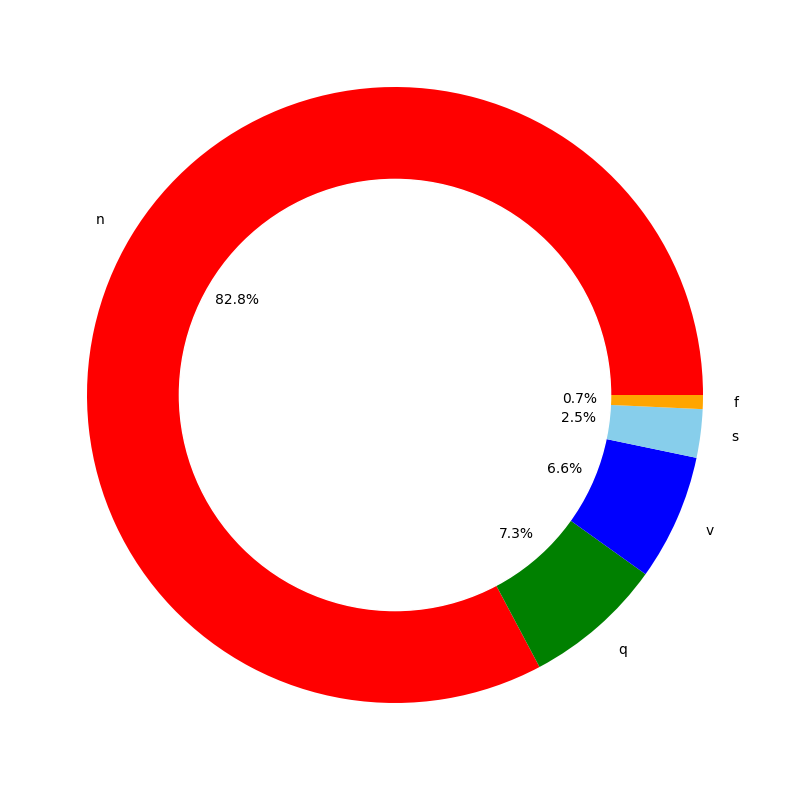

In [5]:
plt.figure(figsize=(20,10))
my_circle=plt.Circle((0,0), 0.7, color='white')
plt.pie(equilibre, labels=['n','q','v','s','f'], colors=['red','green','blue','skyblue','orange'],autopct='%1.1f%%')
p=plt.gcf()
p.gca().add_artist(my_circle)
plt.show()

In [6]:
# Resample the data to have the same number of samples each class
from sklearn.utils import resample
df_1=train_df[train_df[187]==1]
df_2=train_df[train_df[187]==2]
df_3=train_df[train_df[187]==3]
df_4=train_df[train_df[187]==4]

# Downsample
df_0=(train_df[train_df[187]==0]).sample(n=10000,random_state=42)

# Upsample
df_1_upsample=resample(df_1,replace=True,n_samples=10000,random_state=123)
df_2_upsample=resample(df_2,replace=True,n_samples=10000,random_state=124)
df_3_upsample=resample(df_3,replace=True,n_samples=10000,random_state=125)
df_4_upsample=resample(df_4,replace=True,n_samples=10000,random_state=126)

train_df=pd.concat([df_0, df_1_upsample, df_2_upsample, df_3_upsample, df_4_upsample])

In [7]:
print(train_df[187].value_counts())

187
0    10000
1    10000
2    10000
3    10000
4    10000
Name: count, dtype: int64


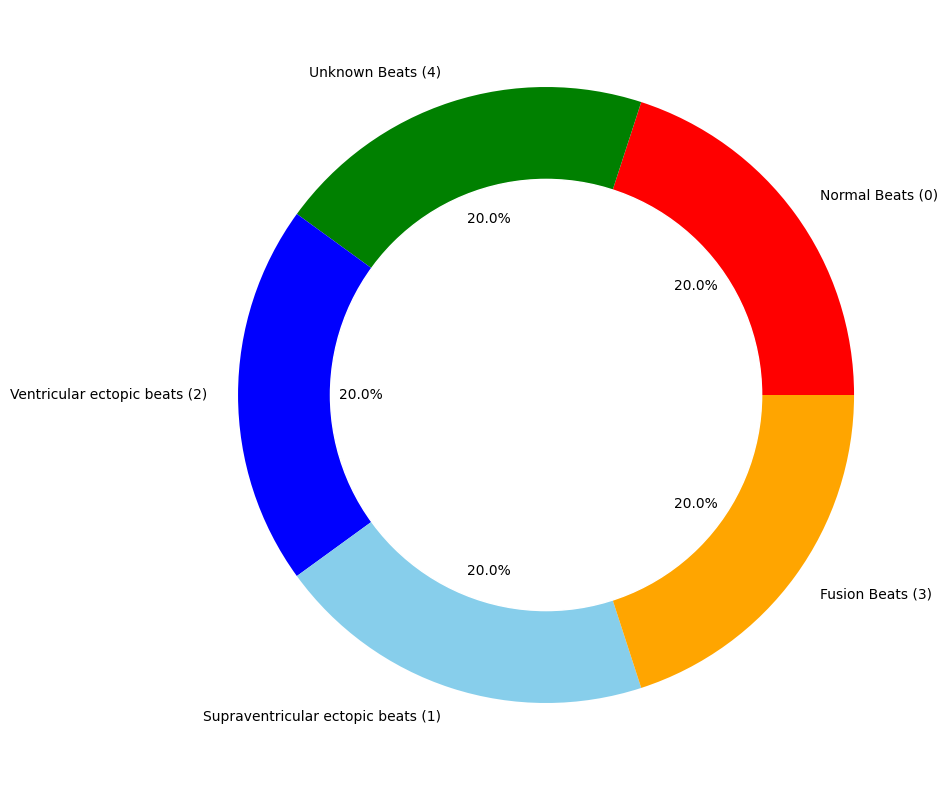

In [8]:
plt.figure(figsize=(20,10))
my_circle = plt.Circle((0,0), 0.7, color='white')
plt.pie(train_df[187].value_counts(), labels=['Normal Beats (0)','Unknown Beats (4)','Ventricular ectopic beats (2)','Supraventricular ectopic beats (1)','Fusion Beats (3)'], colors=['red','green','blue','skyblue','orange'],autopct='%1.1f%%')
p=plt.gcf()
p.gca().add_artist(my_circle)
plt.show()

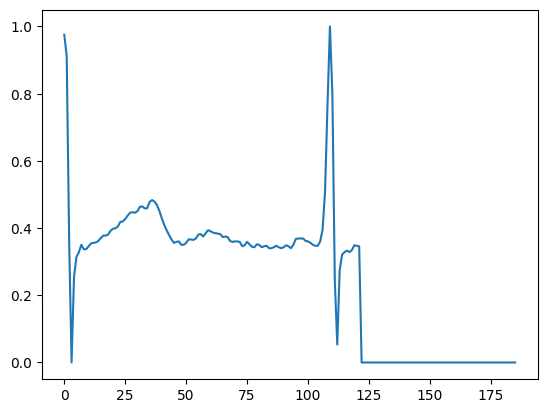

In [9]:
c=train_df.groupby(187,group_keys=False).apply(lambda train_df : train_df.sample(1)) # c is a dataframe with one sample of each class

# Plot the sample of class 0
plt.plot(c.iloc[0, :186])

## Data Preprocessing

### Emulate the noise of the ECG signal

In [10]:
# Function to apply Gaussian noise to a signal
def add_gaussian_noise(signal):
    noise=np.random.normal(0, 0.13, 186)
    return (signal + noise)

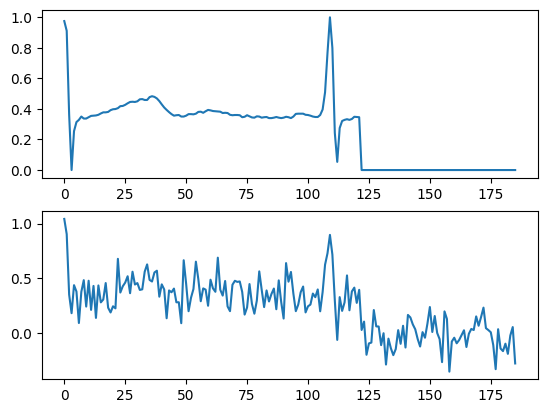

In [11]:
# Add noise to the ECG signal
tempo=c.iloc[0,:186] # tempo is one beat of class 0, c is the dataframe containing the sample of class 0
bruiter=add_gaussian_noise(tempo)

plt.subplot(2,1,1)
# Plot the normal ECG signal
plt.plot(c.iloc[0,:186])

plt.subplot(2,1,2)
# Plot the ECG signal with noise
plt.plot(bruiter)

plt.show()

### Using pywt package to denoise the ECG signal

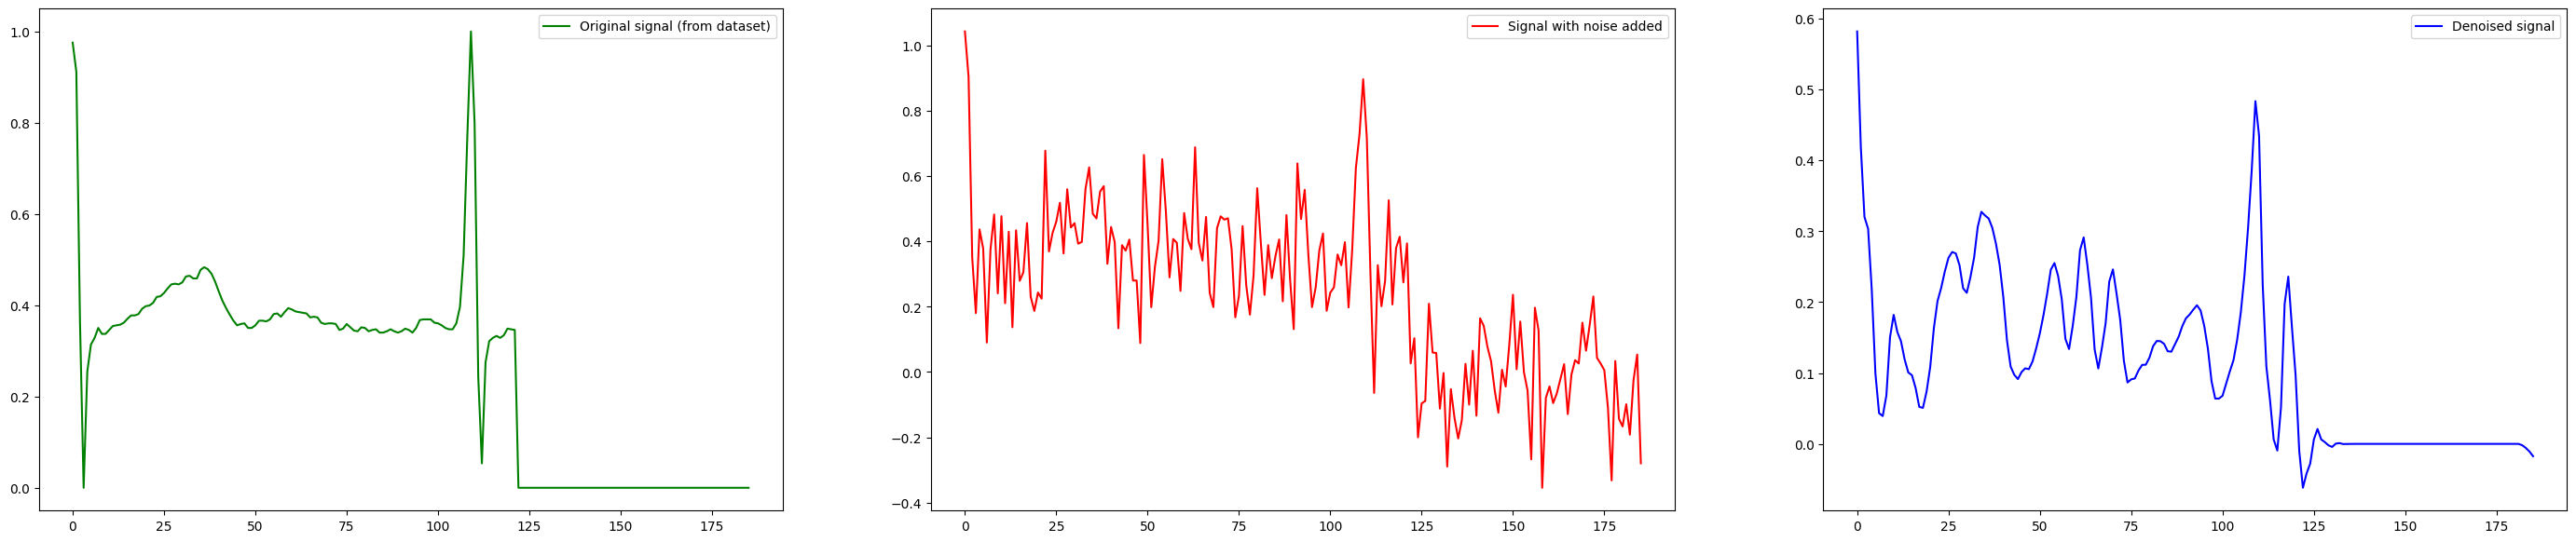

In [12]:
# Plot the original signal (in dataset), the noisy signal and the denoised signal (using wavelet transform)

import pywt

# Load ECG data
before_ecg_data = bruiter

# Apply wavelet transform
coeffs = pywt.wavedec(before_ecg_data, 'db4', level=2)

# Set threshold
sigma = np.median(np.abs(coeffs[-1])) / 0.6745
threshold = sigma * np.sqrt(2 * np.log(len(before_ecg_data)))

# Apply soft thresholding
coeffs = [pywt.threshold(i, value=threshold, mode='soft') for i in coeffs]


# Reconstruct signal from wavelet coefficients
reconstructed_ecg = pywt.waverec(coeffs, 'db4')

plt.figure(figsize=(35, 7))

# Original signal (in dataset)
plt.subplot(1, 3, 1)
plt.plot(tempo, color='green', label='Original signal (from dataset)')
plt.legend()

# Plot the noisy signal
plt.subplot(1, 3, 2)
plt.plot(before_ecg_data, color='red', label='Signal with noise added')
plt.legend()

# Plot the reconstructed signal
plt.subplot(1, 3, 3)
plt.plot(reconstructed_ecg, color='blue', label='Denoised signal')
plt.legend()

plt.show()

### Denoise signal function

In [13]:
def denoise_signal(signal):
    # Apply wavelet transform
    coeffs = pywt.wavedec(signal, 'db4', level=2)

    # Set threshold
    sigma = np.median(np.abs(coeffs[-1])) / 0.6745
    threshold = sigma * np.sqrt(2 * np.log(len(signal)))

    # Apply soft thresholding
    coeffs = [pywt.threshold(i, value=threshold, mode='soft') for i in coeffs]

    # Reconstruct signal from wavelet coefficients
    reconstructed_signal = pywt.waverec(coeffs, 'db4')

    return reconstructed_signal

# Apply the function to denoise the signal
# denoised_ecg = denoise_signal(bruiter)

# plt.figure(figsize=(20, 10))
# plt.subplot(1, 2, 1)
# plt.plot(bruiter, color='red', label='Noisy signal')
# plt.legend()
# plt.subplot(1, 2, 2)
# plt.plot(denoised_ecg, color='blue', label='Denoised signal')
# plt.legend()

### Plot some beats before adding noise

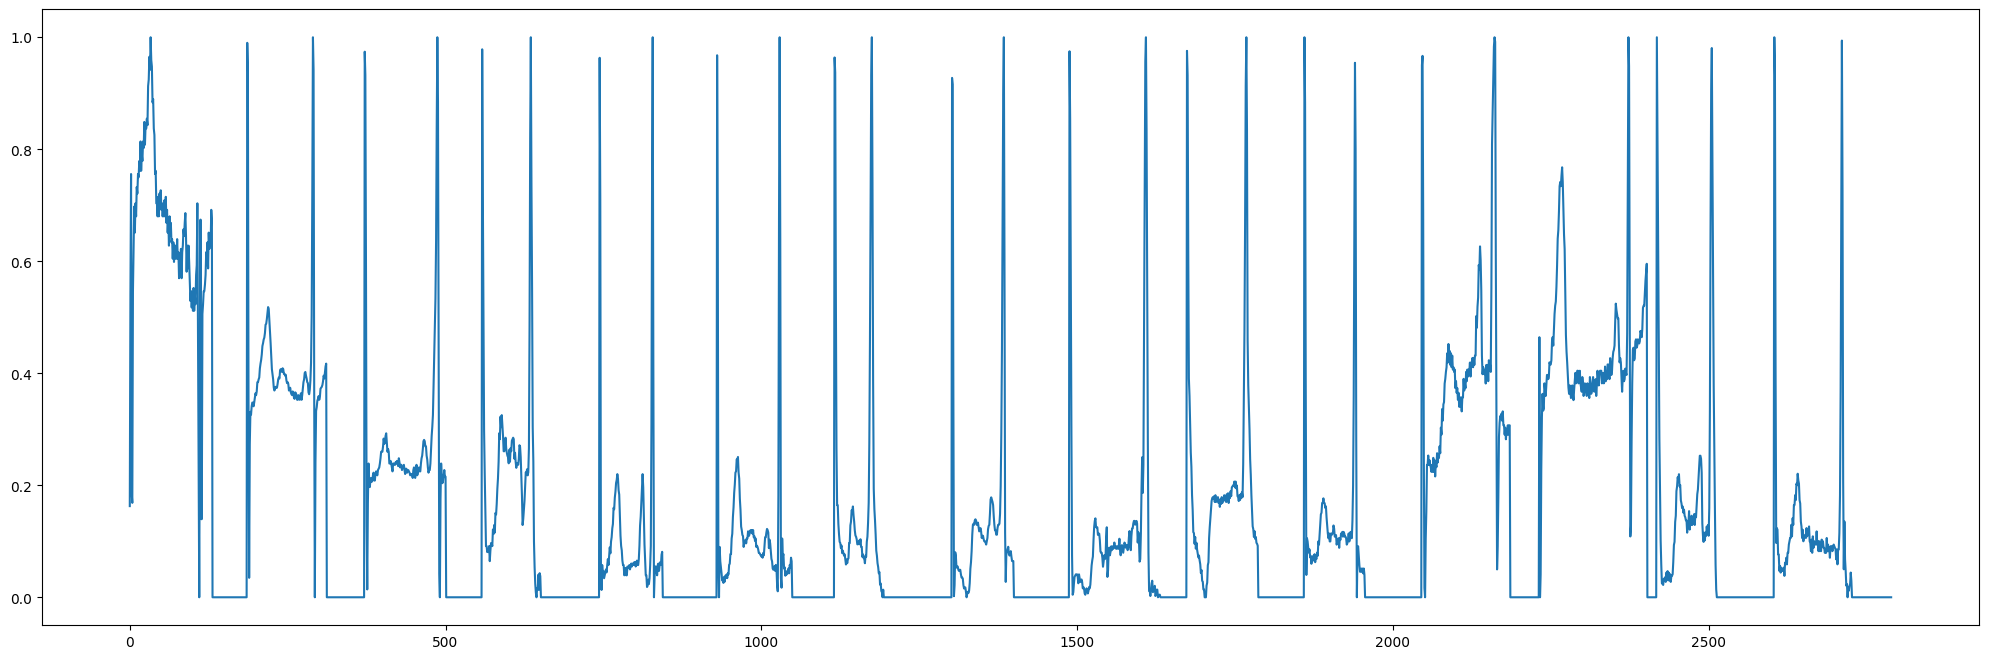

In [14]:
# Concatenate some beats of a class
concatenated_beats = train_df[train_df[187]==0].iloc[0:15, :186].values.flatten() # 6 beats of class 0
# concatenated_beats = train_df[train_df[187]==1].iloc[0:10, :186].values.flatten() # 6 beats of class 1
# concatenated_beats = train_df[train_df[187]==2].iloc[0:6, :186].values.flatten() # 6 beats of class 2
# concatenated_beats = train_df[train_df[187]==3].iloc[0:6, :186].values.flatten() # 6 beats of class 3
# concatenated_beats = train_df[train_df[187]==4].iloc[0:6, :186].values.flatten() # 6 beats of class 4

# Plot the concatenated beats of class 0 (normal beats)
plt.figure(figsize=(25, 8))
plt.plot(concatenated_beats)
plt.show()



### Plot some beats with noise added

In [15]:
# # Select the class to plot
# class_label = 0
# selected_data = X_train[y_train[:, class_label] == 1][:10]

# # Add noise to the selected data
# noised_data = np.apply_along_axis(add_gaussian_noise, 1, selected_data)

# # Concatenate the selected and noised data
# concatenated_data = noised_data.flatten()

# # Plot the concatenated data
# plt.figure(figsize=(25, 8))
# plt.plot(concatenated_data)
# plt.show()


## Classification

### Model Architecture

In [21]:
# Model
from keras.layers import Dense, Convolution1D, MaxPool1D, Flatten, Dropout
from keras.layers import Input
from keras.models import Model
from keras.layers import BatchNormalization
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from sklearn.metrics import confusion_matrix

def network(X_train,y_train,X_test,y_test):
    im_shape=(X_train.shape[1], 1)

    inputs_cnn=Input(shape=(im_shape), name='inputs_cnn')

    conv1_1=Convolution1D(128, (6), activation='relu', input_shape=im_shape)(inputs_cnn)
    conv1_1=BatchNormalization()(conv1_1)

    pool1=MaxPool1D(pool_size=(3), strides=(2), padding="same")(conv1_1)

    conv2_1=Convolution1D(128, (3), activation='relu', input_shape=im_shape)(pool1)
    conv2_1=BatchNormalization()(conv2_1)

    pool2=MaxPool1D(pool_size=(2), strides=(2), padding="same")(conv2_1)

    conv3_1=Convolution1D(128, (3), activation='relu', input_shape=im_shape)(pool2)
    conv3_1=BatchNormalization()(conv3_1)

    pool3=MaxPool1D(pool_size=(2), strides=(2), padding="same")(conv3_1)

    flatten=Flatten()(pool3)

    dense_end1 = Dense(64, activation='relu')(flatten)
    dense_end1 = Dropout(0.5)(dense_end1)
    dense_end2 = Dense(32, activation='relu')(dense_end1)
    dense_end2 = Dropout(0.5)(dense_end2)
    main_output = Dense(5, activation='softmax', name='main_output')(dense_end2)
    
    
    model = Model(inputs = inputs_cnn, outputs = main_output)
    
    # The default learning rate for Adam optimizer is 0.001
    model.compile(optimizer='adam', loss='categorical_crossentropy',metrics = ['accuracy'])
    
    
    callbacks = [EarlyStopping(monitor='val_loss', patience=3), ModelCheckpoint(filepath='best_model.h5', monitor='val_loss', save_best_only=True), ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2)]

    history=model.fit(X_train, y_train, epochs=5, callbacks=callbacks, batch_size=32, validation_data=(X_test,y_test))
    model.load_weights('best_model.h5')
    return(model, history)

### Evaluate function

In [17]:
# Evaluate function
def evaluate_model(history, X_test, y_test, model):
    scores = model.evaluate((X_test), y_test, verbose=0)
    print("Accuracy: %.2f%%" % (scores[1]*100))
    
    print(history)
    fig1, ax_acc = plt.subplots()
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Model - Accuracy')
    plt.legend(['Training', 'Validation'], loc='lower right')
    plt.show()
    
    fig2, ax_loss = plt.subplots()
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Model - Loss')
    plt.legend(['Training', 'Validation'], loc='upper right')
    
    # Plot the loss curve for training and validation
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.show()
    target_names=['0','1','2','3','4']
    
    y_true=[]
    for element in y_test:
        y_true.append(np.argmax(element))
    prediction_proba=model.predict(X_test)
    prediction=np.argmax(prediction_proba,axis=1)
    cnf_matrix = confusion_matrix(y_true, prediction)

### Confusion Matrix

In [26]:
import itertools
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import numpy as np


def plot_and_compute_confusion_matrix(y_test, y_pred, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    # Compute confusion matrix
    cnf_matrix = confusion_matrix(y_test.argmax(axis=1), y_pred.argmax(axis=1))
    np.set_printoptions(precision=2)

    if normalize:
        cnf_matrix = cnf_matrix.astype(
            'float') / cnf_matrix.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.imshow(cnf_matrix, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cnf_matrix.max() / 2.
    for i, j in itertools.product(range(cnf_matrix.shape[0]), range(cnf_matrix.shape[1])):
        plt.text(j, i, format(cnf_matrix[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cnf_matrix[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

### One-hot encoding

In [18]:
# Use to_categorical function from keras to one-hot encode y_train and y_test
from keras.utils import to_categorical

target_train=train_df[187]
target_test=test_df[187]
y_train=to_categorical(target_train)
y_test=to_categorical(target_test)

In [42]:
print(y_test.shape)

(21892, 5)


### Case 0: Data without any pre-processing

In [19]:
X_train=train_df.iloc[:, :186].values
X_test=test_df.iloc[:, :186].values

# Reshape the data to fit the model
X_train = X_train.reshape(len(X_train), X_train.shape[1], 1)
X_test = X_test.reshape(len(X_test), X_test.shape[1], 1)

In [20]:
# Train the model
model_0, history_0 = network(X_train,y_train,X_test,y_test)

Epoch 1/8
1563/1563 [==============================] - 49s 30ms/step - loss: 0.8806 - accuracy: 0.6814 - val_loss: 0.5670 - val_accuracy: 0.8546 - lr: 0.0010
Epoch 2/8
1563/1563 [==============================] - 51s 33ms/step - loss: 0.4966 - accuracy: 0.8357 - val_loss: 0.4685 - val_accuracy: 0.8577 - lr: 0.0010
Epoch 3/8
1563/1563 [==============================] - 50s 32ms/step - loss: 0.3684 - accuracy: 0.8777 - val_loss: 0.3141 - val_accuracy: 0.9136 - lr: 0.0010
Epoch 4/8
1563/1563 [==============================] - 53s 34ms/step - loss: 0.2932 - accuracy: 0.9051 - val_loss: 0.2789 - val_accuracy: 0.9205 - lr: 0.0010
Epoch 5/8
1563/1563 [==============================] - 52s 33ms/step - loss: 0.2493 - accuracy: 0.9211 - val_loss: 0.2759 - val_accuracy: 0.9051 - lr: 0.0010
Epoch 6/8
1563/1563 [==============================] - 50s 32ms/step - loss: 0.2146 - accuracy: 0.9326 - val_loss: 0.2808 - val_accuracy: 0.9125 - lr: 0.0010
Epoch 7/8
1563/1563 [==============================]

Accuracy: 92.58%


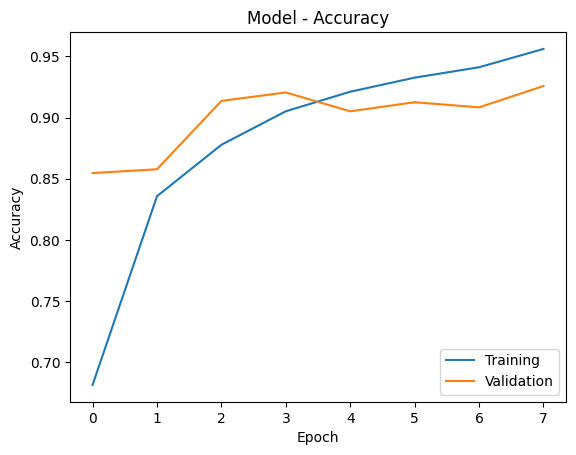

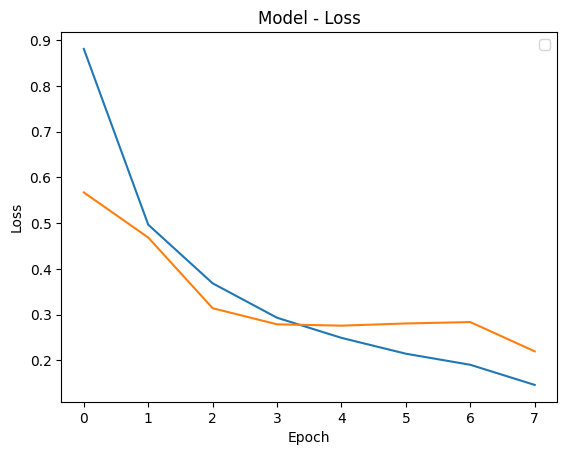

685/685 [==============================] - 4s 6ms/step


In [22]:
# Evaluate the model
evaluate_model(history_0, X_test,y_test, model_0)
y_pred_0 = model_0.predict(X_test)

In [157]:
# Define a class names array
class_names = ['Normal beat', 'Supraventricular ectopic beat',
               'Ventricular ectopic beat', 'Fusion beat', 'Unknown beat']

In [158]:
# Util: Function to get a random sample of a specified class
def get_sample_of_class(X_test, y_test, class_label):
    # Convert y_test from one-hot encoding to label encoding
    y_test_label_encoded = np.argmax(y_test, axis=1)
    
    # Get indices of samples belonging to the specified class
    indices = np.where(y_test_label_encoded == class_label)[0]

    if len(indices) > 0:
        # If there are samples of the specified class, select one at random
        index = np.random.choice(indices)
        return X_test[index]
    else:
        # If there are no samples of the specified class, return None
        return None

In [182]:
# Get a sample of a specified class
CLASS_LABEL_NUMBER = 3
sample = get_sample_of_class(X_test, y_test, CLASS_LABEL_NUMBER)

# Function to print the prediction of the model
def print_prediction(model, sample):
    if sample is not None:
        # Get the model's prediction for the specified sample
        prediction = model.predict(sample.reshape(1, 186, 1))[0]

        for i, prob in enumerate(prediction):
            print(f'{i} - {class_names[i]} - probability: {prob * 100:.3f}%')
    else:
        print('No sample of the specified class found.')


# Print the model's prediction
print_prediction(model_0, sample)

1/1 [==============================] - 0s 20ms/step
0 - Normal beat - probability: 83.590%
1 - Supraventricular ectopic beat - probability: 3.989%
2 - Ventricular ectopic beat - probability: 3.595%
3 - Fusion beat - probability: 8.822%
4 - Unknown beat - probability: 0.005%


Normalized confusion matrix


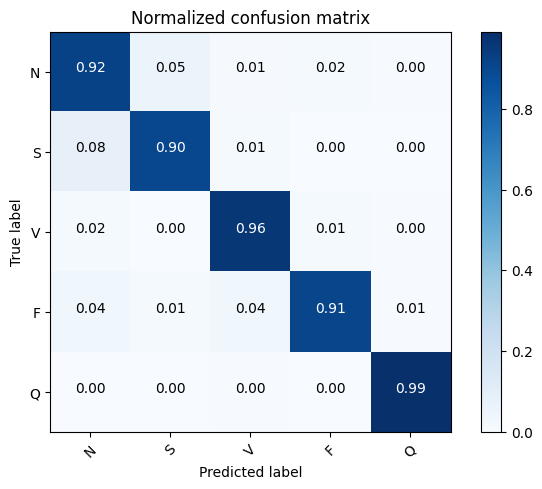

In [27]:
plot_and_compute_confusion_matrix(y_test, y_pred_0, classes=['N', 'S', 'V', 'F', 'Q'], normalize=True, title='Normalized confusion matrix')

### Case 1: Data with noise added

In [68]:
# Copy the original dataframe
X_train_noisy = train_df.iloc[:, :186].values
X_test_noisy = test_df.iloc[:, :186].values

# Loop over each sample, add noise to it
for i in range(len(X_train_noisy)):
    X_train_noisy[i,:186] = add_gaussian_noise(X_train_noisy[i, :186])

# Reshape X_train_noisy and X_test_noisy to be able to feed it to the network
X_train_noisy = X_train_noisy.reshape(len(X_train_noisy), X_train_noisy.shape[1], 1)
X_test_noisy = X_test_noisy.reshape(len(X_test_noisy), X_test_noisy.shape[1], 1)

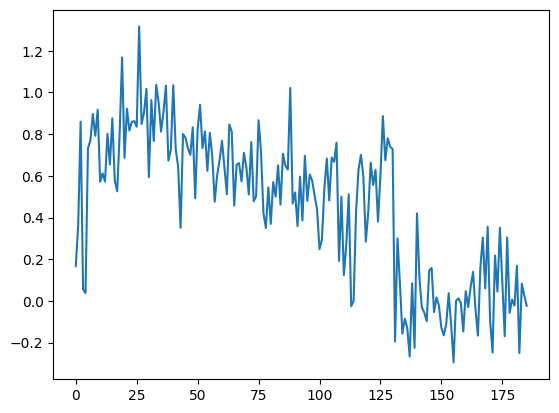

In [91]:
plt.plot(X_train_noisy[0,:186])

In [89]:
model_1, history_1 = network(X_train_noisy, y_train, X_test, y_test)

Epoch 1/8
1563/1563 [==============================] - 56s 35ms/step - loss: 1.0209 - accuracy: 0.5976 - val_loss: 0.8019 - val_accuracy: 0.7944 - lr: 0.0010
Epoch 2/8
1563/1563 [==============================] - 54s 34ms/step - loss: 0.7320 - accuracy: 0.7281 - val_loss: 0.4634 - val_accuracy: 0.9382 - lr: 0.0010
Epoch 3/8
1563/1563 [==============================] - 52s 33ms/step - loss: 0.6417 - accuracy: 0.7632 - val_loss: 0.5521 - val_accuracy: 0.9163 - lr: 0.0010
Epoch 4/8
1563/1563 [==============================] - 53s 34ms/step - loss: 0.5999 - accuracy: 0.7824 - val_loss: 0.6641 - val_accuracy: 0.8022 - lr: 0.0010
Epoch 5/8
1563/1563 [==============================] - 58s 37ms/step - loss: 0.5361 - accuracy: 0.8074 - val_loss: 0.5805 - val_accuracy: 0.8159 - lr: 5.0000e-04
Epoch 6/8
1563/1563 [==============================] - 55s 35ms/step - loss: 0.5105 - accuracy: 0.8163 - val_loss: 0.4671 - val_accuracy: 0.9168 - lr: 5.0000e-04


Accuracy: 93.82%


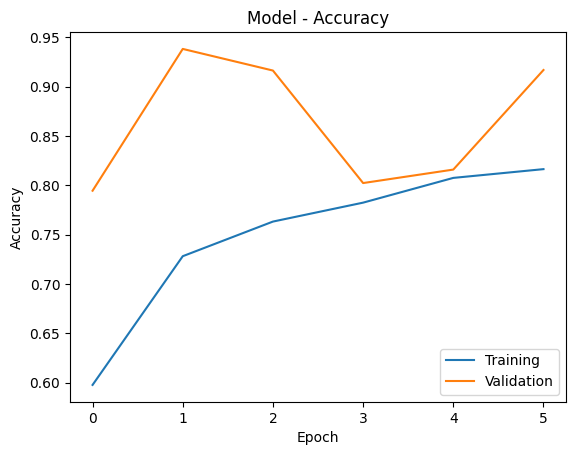

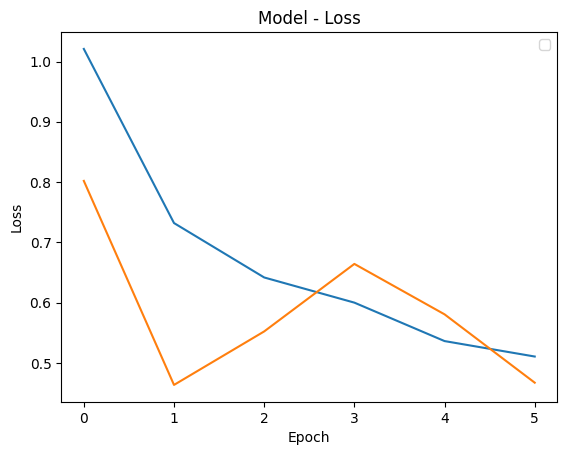

685/685 [==============================] - 5s 8ms/step


In [90]:
# Evaluate the model
evaluate_model(history_1, X_test, y_test, model_1)
y_pred_1 = model_1.predict(X_test)

### Case 2: Preprocessing noised data with Wavelet Transform, then train the model

In [81]:
# Copy the original dataframe
X_train_c2 = train_df.iloc[:, :186].values
X_test_c2 = test_df.iloc[:, :186].values

# Loop over each sample, add noise to it
for i in range(len(X_train_c2)):
    X_train_c2[i,:186] = add_gaussian_noise(X_train_c2[i, :186])
    X_train_c2[i,:186] = denoise_signal(X_train_c2[i, :186])

# Reshape X_train_noisy and X_test_noisy to be able to feed it to the network
X_train_pre = X_train_c2.reshape(len(X_train_c2), X_train_c2.shape[1], 1)

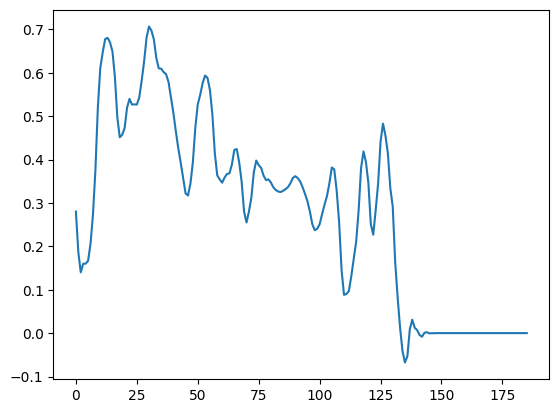

In [82]:
# Plot the denoised signal
plt.plot(X_train_pre[0,:186])

In [85]:
# Train the model
model_2, history_2 = network(X_train_pre, y_train, X_test, y_test)

Epoch 1/8
1563/1563 [==============================] - 57s 35ms/step - loss: 0.9947 - accuracy: 0.6335 - val_loss: 0.9740 - val_accuracy: 0.7112 - lr: 0.0010
Epoch 2/8
1563/1563 [==============================] - 53s 34ms/step - loss: 0.7382 - accuracy: 0.7301 - val_loss: 0.9219 - val_accuracy: 0.8602 - lr: 0.0010
Epoch 3/8
1563/1563 [==============================] - 53s 34ms/step - loss: 0.6695 - accuracy: 0.7590 - val_loss: 0.8819 - val_accuracy: 0.7373 - lr: 0.0010
Epoch 4/8
1563/1563 [==============================] - 53s 34ms/step - loss: 0.6290 - accuracy: 0.7758 - val_loss: 0.5405 - val_accuracy: 0.9048 - lr: 0.0010
Epoch 5/8
1563/1563 [==============================] - 51s 33ms/step - loss: 0.5980 - accuracy: 0.7868 - val_loss: 0.6636 - val_accuracy: 0.8712 - lr: 0.0010
Epoch 6/8
1563/1563 [==============================] - 53s 34ms/step - loss: 0.5756 - accuracy: 0.7970 - val_loss: 0.6117 - val_accuracy: 0.8016 - lr: 0.0010
Epoch 7/8
1563/1563 [==============================]

Accuracy: 90.48%


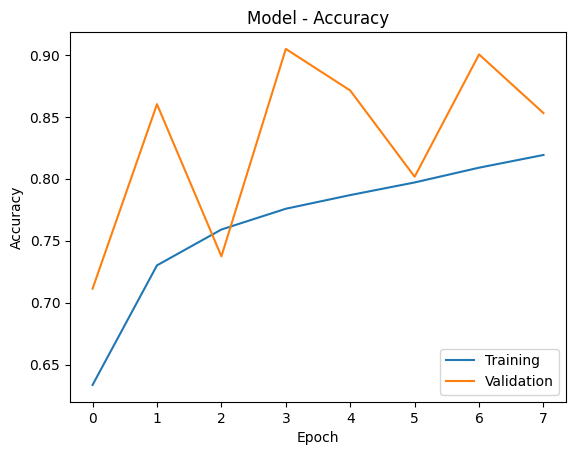

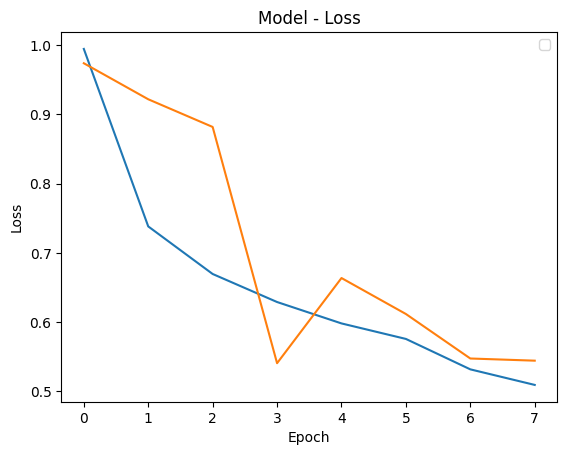

685/685 [==============================] - 5s 7ms/step


In [86]:
# Evaluate the model
evaluate_model(history_2, X_test, y_test, model_2)
y_pred_2 = model_2.predict(X_test)